In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from inpainting.dataset import Data, ResizeTransform, ConditionSampler
from gan.conditional_gan import CGenerator5Net, CDiscriminator5, train
from torch.utils.data import DataLoader 
from torch.utils.data.dataset import Subset
import torch
import matplotlib.pyplot as plt
import pandas as pd
from inpainting.visualize import plot_batch
from inpainting.visualize import cGanPlotLossCallback, ConditionDescriptor

%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
DATA_PATH = 'data/img_align_celeba'
BATCH_SIZE = 512
NUM_WORKERS = 1
Z_SIZE = 100
MODEL_PATH = 'conditional_model/'
LOAD_MODEL = True
LOAD_EPOCH_N = 230
CONTINUE_TRAINING = True
torch.cuda.set_device(1)

In [3]:

transform = ResizeTransform()
data = Data(DATA_PATH, Z_SIZE, transform, return_attr=True)
y_sampler = ConditionSampler(data)
Y_SIZE = data.y_size
#data = Subset(data, range(100))
data_loader = DataLoader(data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
print('Dataset size: ', len(data))
print('y size: ', Y_SIZE)


Dataset size:  202599
y size:  5


[-1.  1. -1.  1. -1.]


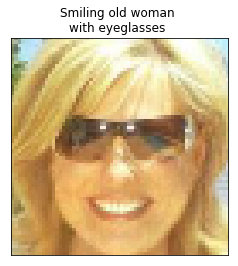

In [7]:
cd = ConditionDescriptor(y_sampler.conditions)
y = cd.create_y(Male=False, Smiling=True, Young=False, Eyeglasses=True)
#y = np.array([0, 1, 0, 0, 0])*2 - 1
idx = data.find_image(y)
img, z, y_new = data[idx]
print(y_new)
plot_batch([img], normalize=True, limit=1, descriptions=[cd.describe(y)])

In [9]:
generator = CGenerator5Net(Z_SIZE, Y_SIZE).cuda()
discriminator = CDiscriminator5(Y_SIZE).cuda()

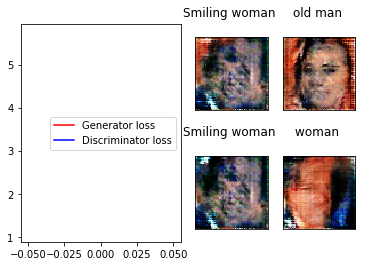

In [16]:
callback = cGanPlotLossCallback(generator, discriminator, y_sampler)
train(generator, discriminator, data_loader, y_sampler=y_sampler,
      n_epochs=269, k=1, callback_func=callback, model_path=MODEL_PATH, 
      continue_training=CONTINUE_TRAINING)


In [10]:
if LOAD_MODEL:
    generator.load_state_dict(torch.load(MODEL_PATH + 'generator_%d.pth' % (LOAD_EPOCH_N,)))
    discriminator.load_state_dict(torch.load(MODEL_PATH + 'discriminator_%d.pth' % (LOAD_EPOCH_N,)))

<class 'numpy.dtype'>
[0.00214267] [-6.143556]
[1.448261e-06] [-13.445146]


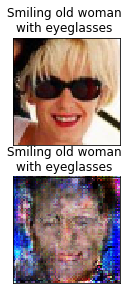

In [18]:
Z = torch.normal(mean=torch.zeros(1, generator.z_size)).cuda()
        # 'Male', 'Smiling', 'Young', 'Eyeglasses', 'Wearing_Hat'
y = cd.create_y(Male=False, Smiling=True, Young=False, Eyeglasses=True)
print(dtype)
idx = data.find_image(y)
img, z, y_new = data[idx]
X = torch.tensor([img]).cuda()
y = y.astype(np.float32)
Y = torch.tensor([
                  y]).cuda()

G_sample = generator(Z, Y)
D_real, D_logit_real = discriminator(X, Y)
D_fake, D_logit_fake = discriminator(G_sample, Y)
print(D_real.data.cpu().numpy()[0], D_logit_real.data.cpu().numpy()[0])
print(D_fake.data.cpu().numpy()[0], D_logit_fake.data.cpu().numpy()[0])
sample = np.concatenate((img[None, :, :, :], G_sample.data.cpu().numpy()))
plot_batch(sample, normalize=True, descriptions=[cd.describe(y)]*2)